# 1. Introduction
**MNIST** - the famous dataset of handwritten digits, which commonly used to learn computer vision basics. Dataset consists of black-and-white images of hand-drawn digits (between 0 and 9).  
In current notebook I will use PyTorch library to create Fully Connected Neural Network in order to determine digit by its handwritten image.

The task was completed as part of the [Getting Started Prediction Competition](https://www.kaggle.com/c/digit-recognizer/).  
The submission file should contain a header and have the following format:  
ImageId,Label  
1,0  
2,0  
3,0  
etc.  

# 2. Import libraries
Pytorch:  
* **torch** - the core package of PyTorch  
* **torch.nn** - the nn package is used for building neural networks (imported as nn)  
* **torch.nn.functional** - contains all the functions in the torch.nn library (imported as F)

Other:  
* **train_test_split** from sklearn.model_selection - to split our train data on train and validation datasets  
* **scikitplot** - to create a confusion matrix (imported as skplt)  
* **pandas** - to load and transform data  (imported as pd)
* **matplotlib.pyplot** - to create some visualizations  (imported as plt)



In [ ]:
import torch                        # The core package of Torch
import torch.nn as nn               # The nn package is used for building neural networks
import torch.nn.functional as F     # Contains all the functions in the torch.nn library

from sklearn.model_selection import train_test_split
import scikitplot as skplt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 3. Prepare data

## 3.1 Load data

As input information I have two CSV files:  
* **train.csv** - contains information about 42 000 (60% of the whole MNIST dataset) gray-scale images of hand-drawn digits (from 0 to 9).  
First column is the digit. The rest 784 columns represent pixels of hand-drawn digit (each image has 28 x 28 pixels shape). The value of each pixel-column is an intager between 0 and 255 - represent darkness or lightness of the given pixel. 
* **test.csv** - contains information about 28 000 gray-scale images of hand-drawn digits (from 0 to 9). Doesn't contain labels. 

In [ ]:
# read data
train_data = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

# check that we loaded data correctly
print("Train data shape:", train_data.shape)
print("Test data shape:", test.shape)

Let's create a barchart to check the number of digits in each class:

In [ ]:
label_counts  = train_data["label"].value_counts().sort_index()
label_counts.plot.bar()
plt.hlines(xmin = -1, xmax = 10, y = 4000, linestyles='dotted')

Split labels and features of training dataset and convert to numpy array:

In [ ]:
train_all = train_data.iloc[:,1:]     # only features (pixels)
train_all_label = train_data["label"] # labels

# convert to numpy array
train_all_numpy = train_all.to_numpy()
train_all_label_numpy = train_all_label.to_numpy()
test_numpy = test.to_numpy()

Lets visualize some train examples with it's labels:

In [ ]:
def plot_img(data, label):
    fig, axs = plt.subplots(3, 3) # 9 images
    k = 0
    for i in range(3):
        for j in range(3):        
            axs[i, j].imshow(data[k].astype('uint8').reshape(28, 28))   # plot image            
            axs[i, j].set_ylabel("label:" + str(label[k].item()))       # print label
            k +=1
plot_img(train_all_numpy, train_all_label_numpy)

## 3.2 Train and validation 

I would like to check my model on unseen data (data I didn't use in the training process) before submitting it.  
Since I don't have labels in test dataset, I will randomly split my treaining data on training and validation datasets in proportion 8:2.  
To do so, I am using train_test_split function from sklearn module:

In [ ]:
# split train on train and validation
train, validation, train_label, validation_label = train_test_split(train_all_numpy, train_all_label_numpy, test_size=0.2)

print(train.shape)
print(train_label.shape)
print(validation.shape)
print(validation_label.shape)

Check if both datasets represent all classes in fair proportion:

In [ ]:
unique, counts_train = np.unique(train_label, return_counts=True)
plt.subplot(1, 2, 1)
plt.bar(unique, counts_train/len(train_label))
unique, counts_val = np.unique(validation_label, return_counts=True)
plt.subplot(1, 2, 2)
plt.bar(unique, counts_val/len(validation_label))
#print (np.asarray((unique, counts_train/len(train_label), counts_val/len(validation_label))).T)

## 3.3 Tensors
Tensor is a multi-dimensional matrix containing elements of a single data type. To use PyTorch, we need to covert our data to tensors.

In [ ]:
train_all_tensor = torch.as_tensor(train_all_numpy).type(torch.FloatTensor)
train_all_label_tensor = torch.as_tensor(train_all_label_numpy)
test_tensor = torch.as_tensor(test_numpy).type(torch.FloatTensor)

train_tensor = torch.as_tensor(train).type(torch.FloatTensor)
train_label = torch.as_tensor(train_label)

validation_tensor = torch.as_tensor(validation).type(torch.FloatTensor)
validation_label = torch.as_tensor(validation_label)

# 4. FNN
## 4.1 neural network architecture

In [ ]:
                   # nn.Module - Base class for all neural network modules.
class FNet(nn.Module):             
    def __init__(self):
        super(FNet, self).__init__()
                   # 784 inputs, connects to hidden layer with 600 nodes
        self.fc1 = nn.Linear(in_features=784, out_features=600)
                   # 600 nodes connects to hidden layer with 500 nodes
        self.fc2 = nn.Linear(in_features=600, out_features=500) 
                   # 500 nodes connects to hidden layer with 250 nodes
        self.fc3 = nn.Linear(in_features=500, out_features=250) 
                   # connection between the last hidden layer 
                   # and the output layer (with 10 nodes)
        self.fc4 = nn.Linear(in_features=250, out_features=10)  
                                                                
    def forward(self, x):
        x = x.view(-1,784)          # Put all the entries of the image in the vector
        x = F.relu(self.fc1(x))     # Input x into first layer and apply a ReLU
                                    # to the nodes in this layer
        x = F.relu(self.fc2(x))        
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x     

### 4.1.2 Layers
A fully connected neural network consists of a series of fully connected layers.  
The first layer takes the 784 (28 x 28) input pixels and connects to the first 600 node hidden layer. Then we have 600 to 500 hidden layer, 500 to 250 hidden layer and in the end the connection between the last hidden layer and the output layer (with 10 nodes).

* input: 784 (image shape)
* 3 hidden layers (600, 500, 250 nodes)
* output: 10 neurons for each possible class

I use **nn.Linear** to constructs a fully connected layer. The first argument is the number of nodes in layer l and the next argument is the number of nodes in layer l+1.

### 4.1.3 Forward method
* First, I need to reshape tensor x, so I use the view function for it.  
* Second, input data x into the first fully connected layer (self.fc1(x)) and then apply a ReLU activation to the nodes in this layer using. * * Because of the hierarchical nature of this network, we replace x at each stage, feeding it into the next layer. 
* We do this through our three fully connected layers, except for the last one.

As activation function, I am using **ReLU** (The Rectified Linear Unit). It gives an output 0 if x is negative and x otherwise. The purpose of the activation function is to introduce non-linearity into the network (non-linear means that the output can not be reproduced from a linear combination of the inputs). To do it in code, I am using F.relu - applies the rectified linear unit function element-wise.

$$
f(x)=max(0,x)
$$

## 4.2 Training the NN

## 4.2.1 Accuracy
Before start the training process, let's define an accuracy function.  
**Accuracy** - fraction of the time classifier is correct.

In [ ]:
def get_accuracy(predictions, true_labels):
    _, predicted = torch.max(predictions, 1)
    corrects = (predicted == true_labels).sum()
    accuracy = 100.0 * corrects/len(true_labels)
    return accuracy.item()

### 4.2.2 Training function

Training process:  
1. Do a forward pass
2. Calculate loss function
3. Calculate the gradients
4. Change the weights based on gradients


The entire training of the network is based on minimizing the loss function. An optimizer determines, based on the loss function, how each parameter should change.  
The optimizer solves the credit assignment problem: how do we assign credit to the parameters when the network performs poorly?

In [ ]:
def training (dataloader, epochs, model, criterion, optimizer):

    train_accuracies, train_losses = [], []
    
    # set the train mode
    model.train()
    
    # loop over training dataset multiple times
    for epoch in range(epochs):        

        train_loss = 0 
        train_accuracy = 0
        num_batch = 0
        
        # iterate over all batches
        for data, labels in dataloader:
            
            # zero the parameters gradient to not accumulate gradients from previous iteration
            optimizer.zero_grad()
            
            # put data into the model
            predictions = net(data)
            
            # calculate loss
            loss = criterion(predictions, labels)
            
            # calculate accuracy
            accurasy = get_accuracy(predictions, labels)
            
            # compute gradients
            loss.backward()
            
            # change the weights
            optimizer.step()
            
            num_batch += 1
            train_loss += loss.item()
            train_accuracy += accurasy
    
        epoch_accuracy = train_accuracy/num_batch
        epoch_loss = train_loss/num_batch        
        train_accuracies.append(epoch_accuracy)
        train_losses.append(epoch_loss)
        
        print("Epoch: {}/{} ".format(epoch + 1, epochs),
              "Training Loss: {:.4f} ".format(epoch_loss),
              "Training accuracy: {:.4f}".format(epoch_accuracy))
    
    return train_accuracies, train_losses
    

### 4.2.3 Train

* **Loss function** - For the loss function I will use **Softmax Cross-Entropy Loss** (nn.CrossEntropyLoss()) - transforms numbers into probabilities. A loss function computes how "bad" a predictions was, compared to the ground truth value for the input. The more accurate the network is, the smaller the loss is. The loss function transforms a problem of finding good weights to perform a task, into an optimization problem: finding the weights that minimize the loss function (or the average value of the loss function across some training data).

* **Optimizer** - I will use **Adam optimizer**(torch.optim.Adam) - a version of gradient descent (by going in the direction of the gradient we are actually going in direction of the local minima of the function).
Parameter lr is learning rate - controls the size of each parameter update step we take. An epoch is a measure of the number of times all training data is used once to update the parameters.

* **DataLoader** - represents a Python iterable over a dataset.
* **batch_size** -  denotes the number of samples contained in each generated batch.
* **epochs** - number of passes through the full training set. 1 Epoch = 1 Forward pass + 1 Backward pass for ALL training samples.

In [ ]:
torch.manual_seed(0)                                      # set seed to make results reproducible

batch_size = 128                                          # Set the batch_size
train_dataset = torch.utils.data.TensorDataset(train_tensor, train_label)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)


epochs = 40                                               # set number of epohs

net = FNet()                                              # initialize network
criterion = nn.CrossEntropyLoss()                         # set criterion
optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer

                                                          # start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

A training curve is a chart that shows:

* The epochs on the x-axis
* The loss and accuracy on the y-axis

In [ ]:
def train_curves(epochs, train_losses, train_accuracies):
    iters = range(1, epochs+1)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    fig.suptitle('Training Curve')
    ax1.plot(iters, train_losses)
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax2.plot(iters, train_accuracies, color = 'g')
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Training Accuracy")
    plt.show()
    
train_curves(epochs, train_losses, train_accuracies)

# 5. Evaluation 
Let’s see the test loss after the training. We switch the module mode to the evaluation mode and check the test loss.

In [ ]:
# set net in test (evaluation) mode
net.eval()    
# get predictions
val_predictions = net(validation_tensor)
val_loss = criterion(val_predictions, validation_label)
val_accurasy = get_accuracy(val_predictions, validation_label)
 
print("Loss: ", str(val_loss.item()), "Accuracy: ", str(val_accurasy))

# to get class with the maximum score as prediction
_, val_predicted = torch.max(val_predictions.data,1)            

# confusion matrix
skplt.metrics.plot_confusion_matrix(validation_label, val_predicted, figsize=(5,5))

Some examples with predicted label:

In [ ]:
plot_img(validation, val_predicted)

And examples of the wrong classified images (with predicted labels):

In [ ]:
# wrong predicted

val_wrong = validation[validation_label != val_predicted]
val_lab_wrong = val_predicted[validation_label != val_predicted]

plot_img(val_wrong, val_lab_wrong)

# 6. Train all 
For the submission I will use model, traind with all possible information,entire train dataset - 42000 labeled examples (60% of the whole MNIST dataset):

In [ ]:
torch.manual_seed(0)                                      # set seed to make results reproducible

batch_size = 128                                          # Set the batch_size
train_all_dataset = torch.utils.data.TensorDataset(train_all_tensor, train_all_label_tensor)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

epochs = 40                                               # set number of epohs

net = FNet()                                              # initialize network
criterion = nn.CrossEntropyLoss()                         # set criterion
optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer

                                                          # start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

In [ ]:
train_curves(epochs, train_losses, train_accuracies)

# 7. Save results

In [ ]:
# set net in test (evaluation) mode
net.eval()  

# get predictions for test data
test_predictions = net(test_tensor)

# to get class with the maximum score as prediction
_, test_predicted = torch.max(test_predictions.data,1)

# Save results in the required format
output = pd.DataFrame({'ImageId': test.index + 1,
                       'Label': test_predicted})
output.to_csv('submission.csv', index=False)
output.head()

As result I got accuracy score = 0.97871  
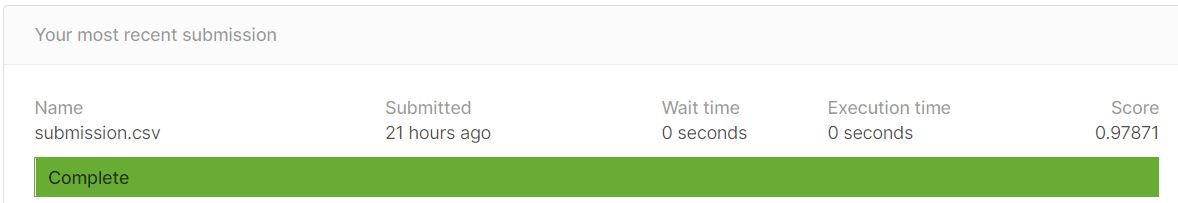

In the next notebook I will use CNN and additional data preparation